### Loading the data

In [1]:
library(tidyverse)
library(ggplot2)
library(readxl)
library(cowplot)
library(broom)
library(GGally)
library(car)
library(MASS)
library(yardstick)
library(knitr)

set.seed(12345)
spotify_data_raw <- read_excel("spotify_most_streamed_songs.xlsx")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some



Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select



A

In [2]:
# Create an environment to enumerate table and picture
table_env <- new.env()
figure_env <- new.env()
table_env$counter <- 0
figure_env$counter <- 0

generate_table_caption <- function(description) {
  table_env$counter <- table_env$counter + 1
  paste("Table", table_env$counter, ":", description)
}
generate_figure_caption <- function(description) {
  figure_env$counter <- figure_env$counter + 1
  paste("Figure", figure_env$counter, ":", description)
}

## (1) Data Description

The dataset that we're going to use for our project is the "Spotify Most Streamed Songs" dataset from Kaggle (https://www.kaggle.com/datasets/abdulszz/spotify-most-streamed-songs). The dataset contains information about the most popular songs on Spotify (as well as additional information for Apple Music and Deezer) encoded as the variables:

In [3]:
str(spotify_data_raw)

tibble [953 × 25] (S3: tbl_df/tbl/data.frame)
 $ track_name          : chr [1:953] "Seven (feat. Latto) (Explicit Ver.)" "LALA" "vampire" "Cruel Summer" ...
 $ artist(s)_name      : chr [1:953] "Latto, Jung Kook" "Myke Towers" "Olivia Rodrigo" "Taylor Swift" ...
 $ artist_count        : num [1:953] 2 1 1 1 1 2 2 1 1 2 ...
 $ released_year       : num [1:953] 2023 2023 2023 2019 2023 ...
 $ released_month      : num [1:953] 7 3 6 8 5 6 3 7 5 3 ...
 $ released_day        : num [1:953] 14 23 30 23 18 1 16 7 15 17 ...
 $ in_spotify_playlists: num [1:953] 553 1474 1397 7858 3133 ...
 $ in_spotify_charts   : num [1:953] 147 48 113 100 50 91 50 43 83 44 ...
 $ streams             : chr [1:953] "141381703" "133716286" "140003974" "800840817" ...
 $ in_apple_playlists  : num [1:953] 43 48 94 116 84 67 34 25 60 49 ...
 $ in_apple_charts     : num [1:953] 263 126 207 207 133 213 222 89 210 110 ...
 $ in_deezer_playlists : num [1:953] 45 58 91 125 87 88 43 30 48 66 ...
 $ in_deezer_charts    : num

The dataset contains 953 observations (songs) and 25 variables (characteristics of the songs). The data was collected by Spotify, accessed through the Spotify API, and made public on Kaggle. The most important variables for our analysis are:

- `streams`: stream count until September 6th 2024
- `track_name`: the name of the song on Spotify
- `artist_name`: the name of the artist on Spotify
- `artist_count`: the number of artists of the song on Spotify
- `released_day`: the day in which the song was released
- `released_month`: the month in which the song was released
- `released_year`: the year in which the song was released
- `bpm`: the overall estimated tempo of the song in beats per minute (BPM)
- `key`: the key in which the song is in
- `mode`: the modality of the song (Minor or Major)
- `danceability_%`: measure of how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity (value of 0.0 is least danceable and 1.0 is most danceable)
- `valence_%`: measure describing the musical positiveness conveyed by a track (value of 0.0 sounds more sad and negative and 1.0 sounds more happy and positive)
- `energy_%`: measure of intensity and activity (value of 0.0 is calm and low energy and 1.0 is noisy and high energy)
- `acousticness_%`: confidence measure of whether the track is acoustic (value of 0.0 is low confidence that song is acoustic and 1.0 is high confidence the song is acoustic)
- `instrumentalness_%`: measure that predicts whether a track contains no vocals (value of 0.0 is high confidence that song contains no vocals and 1.0 is low confidence that song contains no vocals)
- `liveness_%`: measure that predicts presence of an audience in the recording (value of 0.0 is low confidence that song is live and 1.0 is high confidence that song was performed live) 

The full documentation of the dataset can be found on https://developer.spotify.com/documentation/web-api/reference/get-audio-features.

Below, I filter the dataset to the variables of interest, convert variables to appropriate variable types, and rename columns.

In [4]:
spotify_data <- spotify_data_raw %>%
                dplyr::select(1, artist_name = `artist(s)_name`, 3:6, 9, 15:23) %>%
                mutate(streams = as.numeric(streams), key = as_factor(key), mode = as_factor(mode))%>%
                dplyr::select(1:10, danceability = `danceability_%`, valence = `valence_%`, energy = `energy_%`, acousticness = `acousticness_%`, instrumentalness = `instrumentalness_%`, liveness = `liveness_%`)
str(spotify_data)

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `streams = as.numeric(streams)`.
Caused by warning:
! NAs introduced by coercion”


tibble [953 × 16] (S3: tbl_df/tbl/data.frame)
 $ track_name      : chr [1:953] "Seven (feat. Latto) (Explicit Ver.)" "LALA" "vampire" "Cruel Summer" ...
 $ artist_name     : chr [1:953] "Latto, Jung Kook" "Myke Towers" "Olivia Rodrigo" "Taylor Swift" ...
 $ artist_count    : num [1:953] 2 1 1 1 1 2 2 1 1 2 ...
 $ released_year   : num [1:953] 2023 2023 2023 2019 2023 ...
 $ released_month  : num [1:953] 7 3 6 8 5 6 3 7 5 3 ...
 $ released_day    : num [1:953] 14 23 30 23 18 1 16 7 15 17 ...
 $ streams         : num [1:953] 1.41e+08 1.34e+08 1.40e+08 8.01e+08 3.03e+08 ...
 $ bpm             : num [1:953] 125 92 138 170 144 141 148 100 130 170 ...
 $ key             : Factor w/ 11 levels "B","C#","F","A",..: 1 2 3 4 4 2 3 3 2 5 ...
 $ mode            : Factor w/ 2 levels "Major","Minor": 1 1 1 1 2 1 2 1 2 2 ...
 $ danceability    : num [1:953] 80 71 51 55 65 92 67 67 85 81 ...
 $ valence         : num [1:953] 89 61 32 58 23 66 83 26 22 56 ...
 $ energy          : num [1:953] 83 74 53 72 

## (2) Question

In this project, we want to estimate the effect of the artist on the number of streams of a song on Spotify. Our primary question of interest is: controlling for song characteristics, for which artists does `artist_name` have a significant effect on the number of `streams` of a Spotify song? This question is focused primarily on statistical inference. A second question we might considering answering is: after taking into account the effect of artist, are any other song characteristics associated with `streams`? This question is also focused on statistical inference.

The input variables we will consider adding to the model are `bpm`, `key`, `mode`, `danceability`, `valence`, `energy`, `acousticness`, `instrumentalness`, `liveliness`, and `artist_name`. These variables provide comprehensive characteristics of the songs as well as who is listed as the artist on Spotify.

## (3) Exploratory Data Analysis and Visualization


I first explore the dataset with the summary statistics of each variable:

In [5]:
summary(spotify_data)

  track_name        artist_name         artist_count   released_year 
 Length:953         Length:953         Min.   :1.000   Min.   :1930  
 Class :character   Class :character   1st Qu.:1.000   1st Qu.:2020  
 Mode  :character   Mode  :character   Median :1.000   Median :2022  
                                       Mean   :1.556   Mean   :2018  
                                       3rd Qu.:2.000   3rd Qu.:2022  
                                       Max.   :8.000   Max.   :2023  
                                                                     
 released_month    released_day      streams               bpm       
 Min.   : 1.000   Min.   : 1.00   Min.   :2.762e+03   Min.   : 65.0  
 1st Qu.: 3.000   1st Qu.: 6.00   1st Qu.:1.416e+08   1st Qu.:100.0  
 Median : 6.000   Median :13.00   Median :2.905e+08   Median :121.0  
 Mean   : 6.034   Mean   :13.93   Mean   :5.141e+08   Mean   :122.5  
 3rd Qu.: 9.000   3rd Qu.:22.00   3rd Qu.:6.739e+08   3rd Qu.:140.0  
 Max.   :12.000   Ma

Based on the statistics above, I notice 2 issues on the data, (1) there is one observation for which `streams == NA` and (2) there are 95 observations for which `key == NA`. For now, I drop the `streams == NA` observation to solve (1) and proceed with the exploratory data analysis with (2) on mind.

In [6]:
spotify_data <- spotify_data %>%
                filter(!is.na(streams))

It is interesting to see that there are no songs with stream counts below 2,000. This suggests that the data is possibly not a random sample of spotify songs.

Next, we look at `artist_name`. We calculate the number of songs from each artist on the dataset.

In [7]:
artist_summary <- spotify_data %>%
    group_by(artist_name) %>%
    summarize(number_songs = n()) %>%
    arrange(desc(number_songs))

caption <- generate_table_caption("Top Artists by Number of Songs")
cat(caption, "\n")

print(artist_summary, n=30)

Table 1 : Top Artists by Number of Songs 
# A tibble: 644 × 2
   artist_name      number_songs
   <chr>                   <int>
 1 Taylor Swift               34
 2 The Weeknd                 22
 3 Bad Bunny                  19
 4 SZA                        19
 5 Harry Styles               17
 6 Kendrick Lamar             12
 7 Morgan Wallen              11
 8 Ed Sheeran                  9
 9 BTS                         8
10 Drake, 21 Savage            8
11 Feid                        8
12 Labrinth                    7
13 Olivia Rodrigo              7
14 Doja Cat                    6
15 NewJeans                    6
16 Billie Eilish               5
17 Adele                       4
18 Arctic Monkeys              4
19 Bruno Mars                  4
20 Drake                       4
21 Eminem                      4
22 IVE                         4
23 Karol G                     4
24 M茂驴陆茂驴陆ne             4
25 Quevedo                     4
26 BLACKPINK                   3
27 Beyonc茂驴         

To calculate the effect of a given artist on streams, we need to have at least a few songs from that artist on the dataset. We set this threshold at 5 - we restrict our artists of interest to those with at least 5 songs on the dataset. 

We see that Drake is listed twice on the snapshot above: once by himself and once with 21 Savage. That happens because some songs are listed under more than one artist, so the data lists both names in the `artist_name` variable. For example, look below at the `artist_name` observations that contain the string `"Taylor Swift"`.

In [8]:
caption <- generate_table_caption("Observations contain Taylor Swift")
cat(caption, "\n")
spotify_data %>% group_by(artist_name) %>% summarize(number_songs = n())%>% arrange(desc(number_songs)) %>% filter(grepl("Taylor", artist_name))

Table 2 : Observations contain Taylor Swift 


artist_name                number_songs
1 Taylor Swift               34          
2 Ed Sheeran, Taylor Swift    1          
3 Lana Del Rey, Taylor Swift  1          
4 Taylor Swift, Ice Spice     1          
5 Taylor Swift, Lana Del Rey  1

This could pose a problem to our analysis: the effects of songs with more than one artist are likely not representative of individual artist effects. The streams of the song by Ed Sheeran and Taylor Swift reflect the effect of both artists combined, which is likely different than that of each artist individually. To solve this issue, we filter our dataset and focus our analysis on songs with a single artist. This reduces our sample size to 586 observations.

In [9]:
stream_data <- spotify_data %>%
                filter(artist_count == 1)
nrow(stream_data)

[1] 586

Now I group the artists with less than 5 songs into a category `artist_name =="other"` and transform the `artist_name` variable into a factor.

In [10]:
artists_5_songs <- stream_data %>% group_by(artist_name) %>% summarize(n =n()) %>% filter(n>4) %>% pull(artist_name)
stream_data <- stream_data %>%
                mutate(artist_name = if_else(artist_name %in% artists_5_songs, artist_name, "other"),
                      artist_name = relevel(as_factor(artist_name), ref="other"))

The summary statistics and most represented artists on our reduced sample are as follows:

In [11]:
summary(stream_data)

  track_name              artist_name   artist_count released_year 
 Length:586         other       :396   Min.   :1     Min.   :1946  
 Class :character   Taylor Swift: 34   1st Qu.:1     1st Qu.:2019  
 Mode  :character   The Weeknd  : 22   Median :1     Median :2022  
                    Bad Bunny   : 19   Mean   :1     Mean   :2017  
                    SZA         : 19   3rd Qu.:1     3rd Qu.:2022  
                    Harry Styles: 17   Max.   :1     Max.   :2023  
                    (Other)     : 79                               
 released_month    released_day      streams               bpm       
 Min.   : 1.000   Min.   : 1.00   Min.   :1.478e+07   Min.   : 65.0  
 1st Qu.: 3.000   1st Qu.: 6.00   1st Qu.:1.674e+08   1st Qu.:100.0  
 Median : 5.000   Median :13.00   Median :3.336e+08   Median :121.5  
 Mean   : 5.986   Mean   :13.87   Mean   :5.682e+08   Mean   :123.6  
 3rd Qu.: 9.000   3rd Qu.:21.00   3rd Qu.:7.953e+08   3rd Qu.:143.0  
 Max.   :12.000   Max.   :31.00   Ma

In [12]:
caption <- generate_table_caption("Reduced sample")
cat(caption, "\n")
stream_data %>% group_by(artist_name) %>% summarize(number_songs = n())%>% arrange(desc(number_songs)) %>% print()

Table 3 : Reduced sample 
# A tibble: 16 × 2
   artist_name    number_songs
   <fct>                 <int>
 1 other                   396
 2 Taylor Swift             34
 3 The Weeknd               22
 4 Bad Bunny                19
 5 SZA                      19
 6 Harry Styles             17
 7 Kendrick Lamar           12
 8 Morgan Wallen            11
 9 Ed Sheeran                9
10 BTS                       8
11 Feid                      8
12 Olivia Rodrigo            7
13 Labrinth                  7
14 NewJeans                  6
15 Doja Cat                  6
16 Billie Eilish             5


Now, I turn to the response variable. As `stream` is a count, the most appropriate type of model will probably be a poisson-type regression model. I start by looking at a histogram of stream counts.

Figure 1 : Histogram of stream counts 


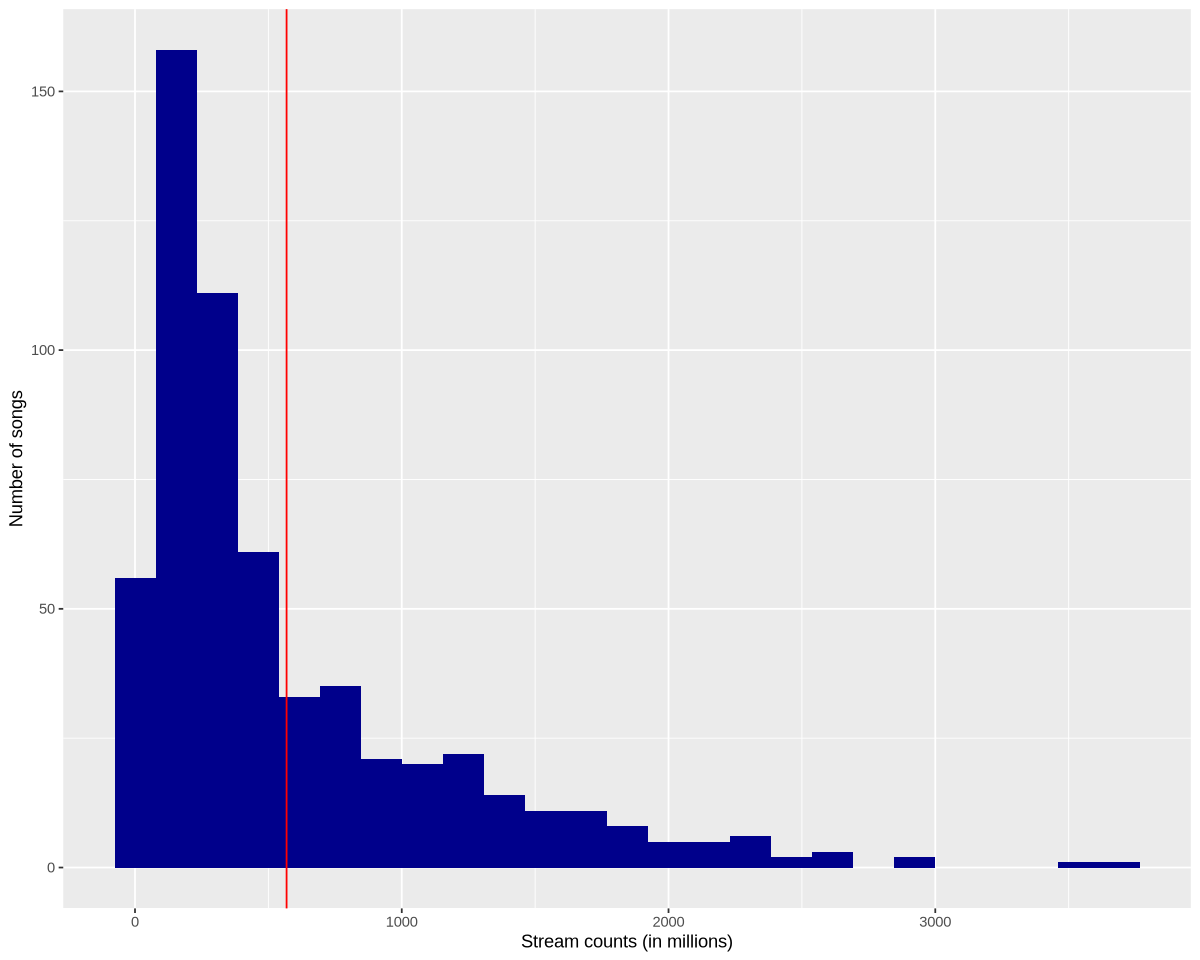

In [13]:
caption <- generate_figure_caption("Histogram of stream counts")
cat(caption, "\n")
options(repr.plot.width=10, repr.plot.height=8)

stream_data <- stream_data %>%
                mutate(streams_millions = streams/1000000)

ggplot(stream_data, aes(x=streams_millions))+
geom_histogram(fill = 'darkblue', bins = 25)+
geom_vline(xintercept = mean(stream_data$streams_millions), color = 'red')+
labs(x = 'Stream counts (in millions)',
    y = 'Number of songs')

The histogram suggests that the variable `streams` seems to follow a poisson distribution. An important assumption of the poisson distribution is that the mean of the response equals its variance. Now I check whether there is overdispersion in the data.

In [14]:
caption <- generate_table_caption("Mean and variance in the data")
cat(caption, "\n")
tibble(Statistic = c("Mean", "Variance"), Value = c(round(mean(stream_data$streams_millions),0), round(var(stream_data$streams_millions),0)))

Table 4 : Mean and variance in the data 


Statistic Value 
1 Mean         568
2 Variance  352436

The variance of the `streams` is much larger than the mean of `streams`. It is likely that we will have to adjust the traditional poisson model to account for overdispersion (or model the response variable with a negative binomial regression).


Now, I try to investigate potential issues with exposure. Since older songs have been in the platform for longer, it is likely that all else equal those songs will have more streams than newer songs (regardless of song characteristics). To check for this potential issues, I look at a boxplot of `streams` for songs released in the last 5 years.

Figure 2 : Stream counts per year released 


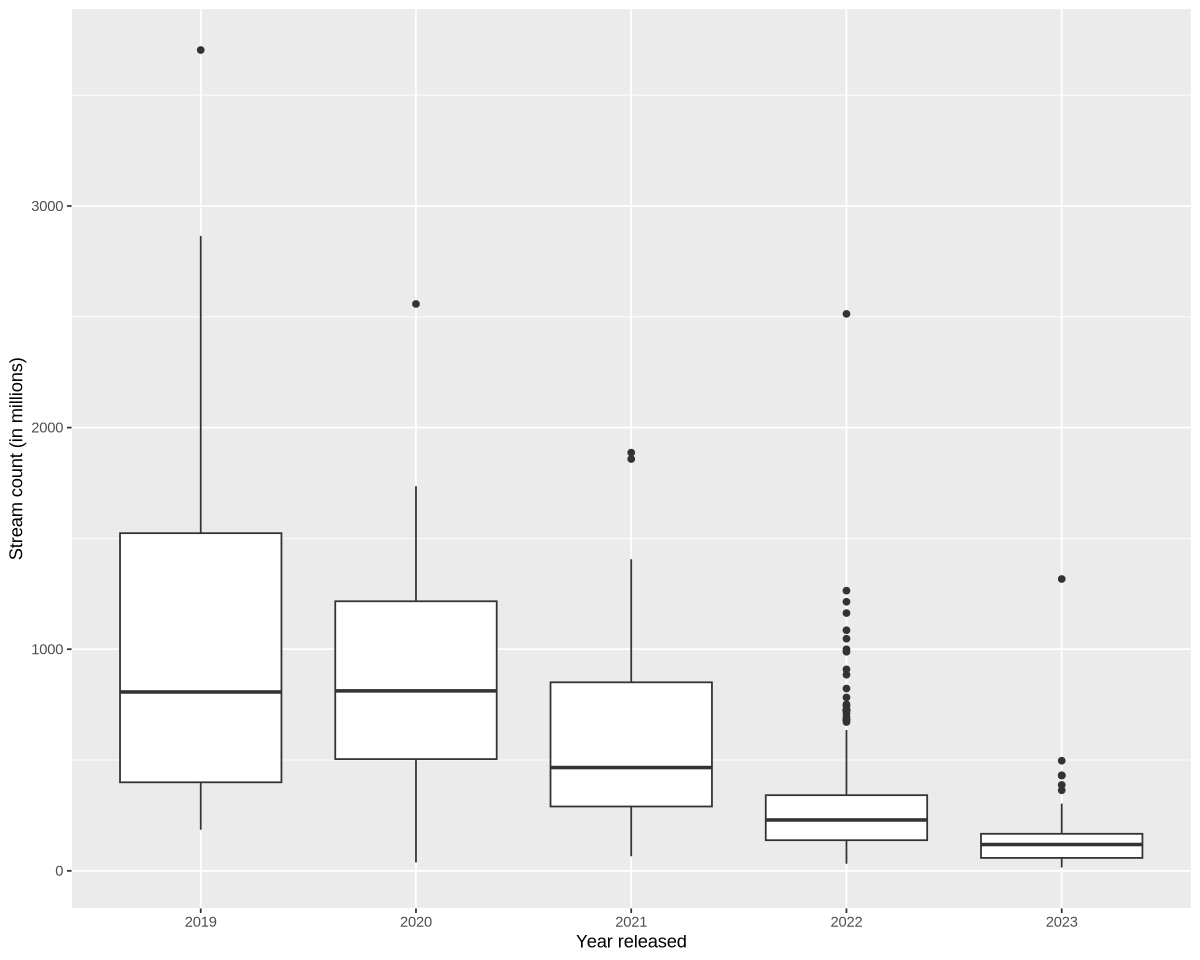

In [15]:
caption <- generate_figure_caption("Stream counts per year released")
cat(caption, "\n")
options(repr.plot.width=10, repr.plot.height=8)
exposure_data <- stream_data %>%
                    filter(released_year > 2018)%>%
                    mutate(released_year = as_factor(released_year))

ggplot(exposure_data, aes(x=released_year, y=streams_millions))+
geom_boxplot()+
labs(y = 'Stream count (in millions)',
    x = 'Year released')

It is clear from this plot that the stream count tends to be larger for songs that have been in Spotify for longer. In the next steps of the project, we should consider adding an offset to the model or adding a predictor to control for the length of time the song has been on the market.

Now, I turn back to the variable `key` and try to understand whether it could add value to the model. If not, we should drop it since it contains ~10% of NAs. I look at the histogram of stream counts for the different levels of `key`.

Figure 3 : Histogram of stream counts per key 


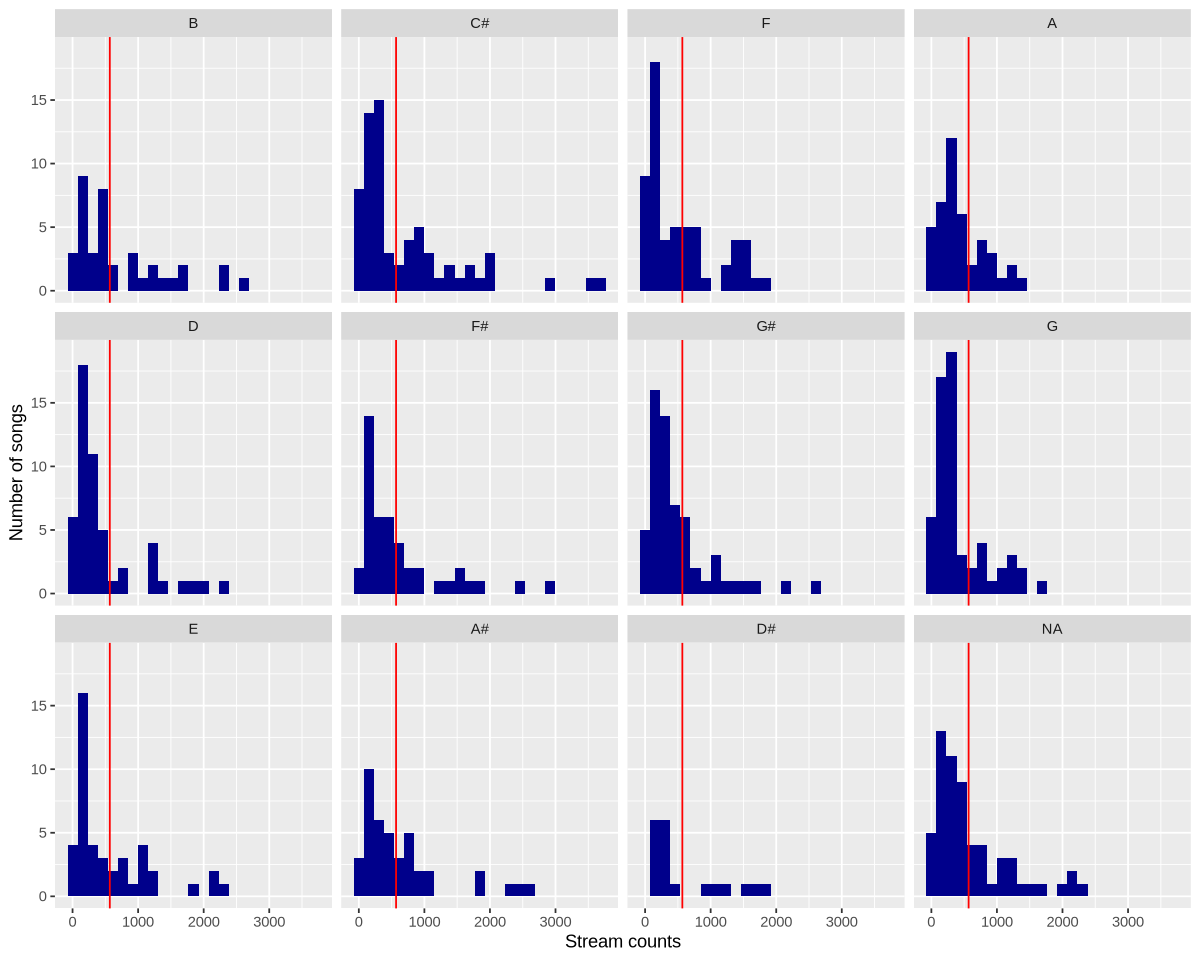

In [16]:
caption <- generate_figure_caption("Histogram of stream counts per key")
cat(caption, "\n")
options(repr.plot.width=10, repr.plot.height=8)

p <- ggplot(stream_data, aes(x=streams_millions))+
geom_histogram(fill = 'darkblue', bins = 25)+
geom_vline(xintercept = mean(stream_data$streams_millions), color = 'red')+
labs(x = 'Stream counts',
    y = 'Number of songs')

p + facet_wrap(vars(key))

The shapes of the histograms look very similar, indicating that `key` possibly doesn't affect the stream count when analyzed individually. We could consider dropping that variable in the following steps of the project. 

Now I conclude the EDA by looking at the other variables: the Spotify scores. I suspect that some of those metrics could potentially be correlated since they all represent harmonic characteristics of the songs. This could cause multicollinearity in our model.

Figure 4 : Pairwise scatterplot matrix of spotify variables 


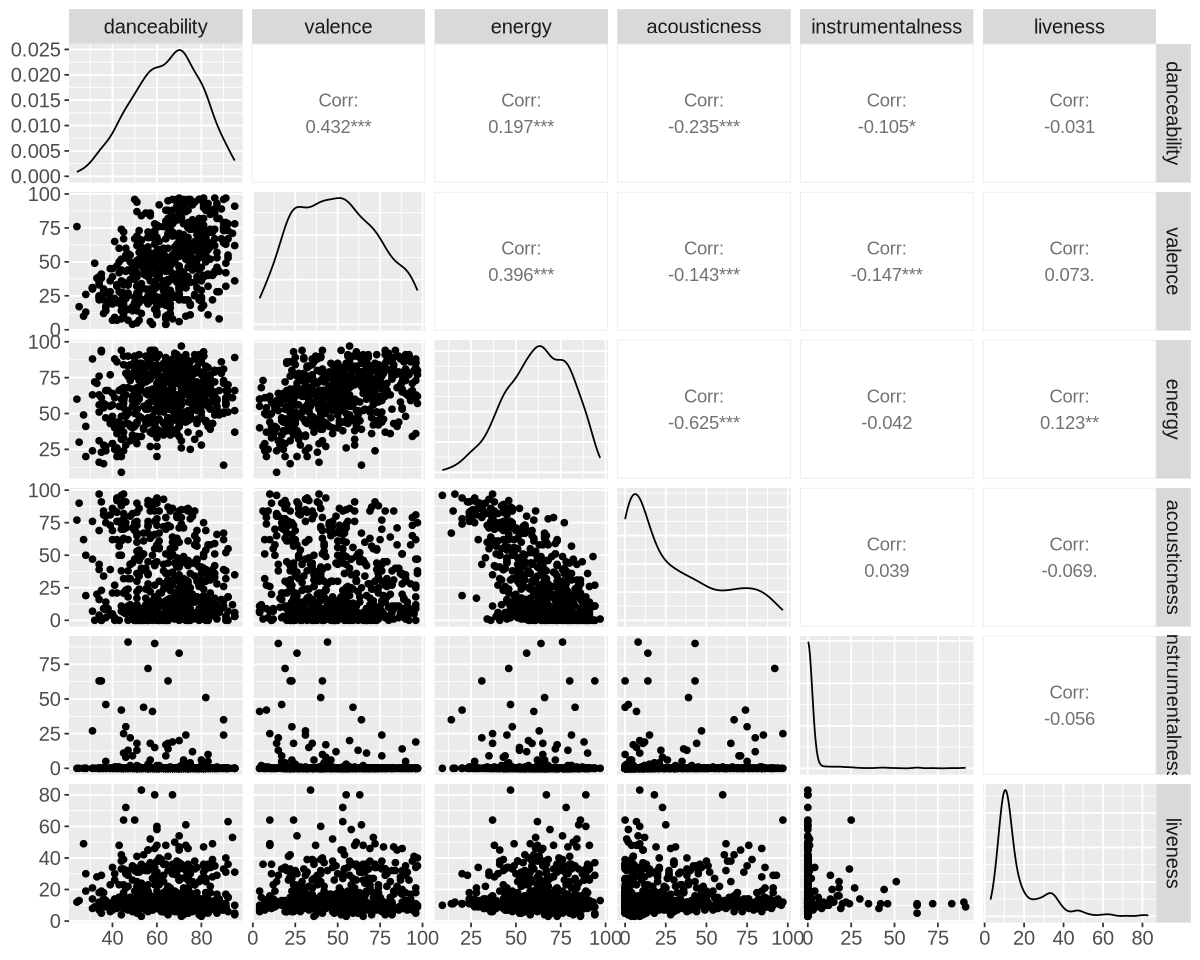

In [17]:
caption <- generate_figure_caption("Pairwise scatterplot matrix of spotify variables")
cat(caption, "\n")
options(repr.plot.width=10, repr.plot.height=8)

spotify_var_plot_data <- stream_data %>%
                        dplyr::select(11:16)

spotify_var_plot <- spotify_var_plot_data %>%
    ggpairs(progress = FALSE) +
    theme(
        text = element_text(size = 15),
        plot.title = element_text(face = "bold"),
        axis.title = element_text(face = "bold")
    )
spotify_var_plot

Looking at the scatterplots and correlations of the the Spotify scores, we see that there could be potential issues with multicollinearity. We see that both `valence` and `acousticness` are correlated with `energy` and `danceability`, with special issues in the correlation between `energy` and `acousticness` $(\rho = -0.625)$ and `valence` and `danceability` $(\rho = 0.432)$. Intuitively, those correlations make sense: acoustic songs tend to be less energetic and positive songs tend to be more danceable.

## (4) Methods and Plan

To address our research question, we employ a quasi-poisson regression model. This model is an extension of the poisson regression with a dispersion parameter that accounts for over-dispersed count data. We believe this method is appropriate for the research question because (1) our response variable `streams` is a count (2) the variance of `streams` exceeds its mean. The assumptions required to apply the poisson method are:

1. The response variable `streams` is a count distributed according to a poisson process
2. The log of the mean rate of `streams` is a linear function of the explanatory variables
3. The mean of the response variable `streams` equals its variance
4. The observations are independent of each other

As we're modeling the response with a quasi-poisson regression, assumption 3 can be relaxed. This is accomplished by inflating the standard errors of the traditional poisson regression with a dispersion parameter

$\hat \phi = \frac{\sum (\text{Pearson residuals})^2}{n-p}$

for some sample size $n$ and number of parameters $p$.

As inspected in the exploratory data analysis, we would likely face the following potential issues with a poisson model:

1. **Exposure**. Stream counts are not directly comparable because the time the songs have been on Spotify differ significantly. All else equal, songs released earlier will tend to have more streams (regardless of song characteristics). To address this issue, we create a new variable to account for the length of time the song has been on Spotify and add it as a predictor to the model.
2. **Overdispersion**. The mean of the response variable does not equal its variance, which could lead to artificially small standard errors. This issue is addressed as we're fitting a quasi-poisson model instead of a traditional poisson model.
3. **Multicollinearity**. Some of the song characteristics that we intend to use as explanatory variables seem to be correlated, which could lead to unstable estimates of the regression coefficients. To address this issue, we start with a long model and consider dropping variables that have high correlation.
4. **Observations are not independent**. As shown in the exploratory data analysis, there are no songs with less than 2,000 streams. This appears to be a rather high minimum number of streams for a random sample of size 950, which suggests that this is possibly not a random sample. We suspect that the sample was collected according to some systematic criteria, which could have caused the selection of correlated observations. Unfortunately, since we have no visibility on the data collection process, it is impossible for us to verify and rectify this potential issue.

## (5) Implementation of a proposed model

In this section we start with a long quasi-poisson model and discuss potential improvements. 

The following code creates a variable that tracks the number of days the song has been on Spotify. This variable will be used to control for different lengths of time that songs have been available to users on Spotify, mitigating the issue of exposure.

In [18]:
model_data <- stream_data %>%
                mutate(release_date = as.Date(paste(as.character(released_year), as.character(released_month), as.character(released_day), sep = "-")),
                      days_on_spotify = as.numeric(as.Date("2024-09-06")-release_date))

Now we drop the following variables:

- `key`: has ~10% of NAs and based on EDA does not appear to affect streams in a meaningful manner.
- `mode`: no reason to add `mode` to the model if we're excluding the `key` variable.

In [19]:
caption <- generate_table_caption("Reduced data")
cat(caption, "\n")
model_data <- model_data %>%
                dplyr::select(-track_name, -artist_count, -released_year, -released_month, -released_day, -key, -mode, -streams_millions, -release_date)

head(model_data)

Table 5 : Reduced data 


artist_name    streams   bpm danceability valence energy acousticness
1 other          133716286  92 71           61      74      7          
2 Olivia Rodrigo 140003974 138 51           32      53     17          
3 Taylor Swift   800840817 170 55           58      72     11          
4 Bad Bunny      303236322 144 65           23      80     14          
5 other           58149378 100 67           26      71     37          
6 other           95217315 130 85           22      62     12          
  instrumentalness liveness days_on_spotify
1  0               10        533           
2  0               31        434           
3  0               11       1841           
4 63               11        477           
5  0               11        427           
6  0               28        480

Now we run the model and show a table with the results.

In [20]:
caption <- generate_table_caption("The results of model")
cat(caption, "\n")
quasip_model <- glm(streams ~ artist_name + bpm + danceability + valence + energy + acousticness + instrumentalness + liveness + offset(log(days_on_spotify)), data=model_data, family = quasipoisson)
tidy(quasip_model)%>% mutate_if(is.numeric, round, 3)

Table 6 : The results of model 


term                      estimate std.error statistic p.value
1  (Intercept)               10.953   0.433     25.288    0.000  
2  artist_nameOlivia Rodrigo  1.655   0.321      5.151    0.000  
3  artist_nameTaylor Swift    0.344   0.230      1.496    0.135  
4  artist_nameBad Bunny       0.821   0.272      3.017    0.003  
5  artist_nameNewJeans        0.457   0.673      0.679    0.497  
6  artist_nameHarry Styles    1.222   0.251      4.874    0.000  
7  artist_nameSZA             0.672   0.394      1.706    0.089  
8  artist_nameBillie Eilish   0.807   0.527      1.531    0.126  
9  artist_nameMorgan Wallen   0.216   0.648      0.333    0.739  
10 artist_nameThe Weeknd      0.742   0.230      3.223    0.001  
11 artist_nameBTS             1.068   0.403      2.649    0.008  
12 artist_nameFeid            0.532   0.563      0.944    0.346  
13 artist_nameEd Sheeran      1.288   0.233      5.522    0.000  
14 artist_nameLabrinth        0.449   0.559      0.803    0.422  
15 artist_nameDoja Cat        0.930   0.392      2.375    0.018  
16 artist_nameKendrick Lamar  0.067   0.483      0.138    0.890  
17 bpm                        0.002   0.002      0.866    0.387  
18 danceability               0.019   0.004      5.087    0.000  
19 valence                   -0.013   0.002     -5.850    0.000  
20 energy                     0.009   0.004      2.423    0.016  
21 acousticness               0.000   0.002     -0.145    0.885  
22 instrumentalness          -0.008   0.006     -1.373    0.170  
23 liveness                   0.000   0.004      0.084    0.933

The results of our model suggest that the artists Olivia Rodrigo, SZA, Morgan Wallen, and Ed Sheeran have statistically significant effects (for a p-value of 0.05) on the stream count of their songs once we control for song characteristics and days on spotify. The effects are positive for Ed Sheeran (2.8 times more streams) and Olivia Rodrigo (2 times more streams), and negative for SZA (decrease of ~50% in streams) and Morgan Wallen (decrease of ~70% in streams). It is also interesting to see that once we control for `artist_name` and `days_on_spotify`, none of the song characteristics are statistically significant.

Now we take a look at the accuracy of our model to understand how reliable our results are. 

Figure 5 : Residuals vs. fitted Values for all artists 


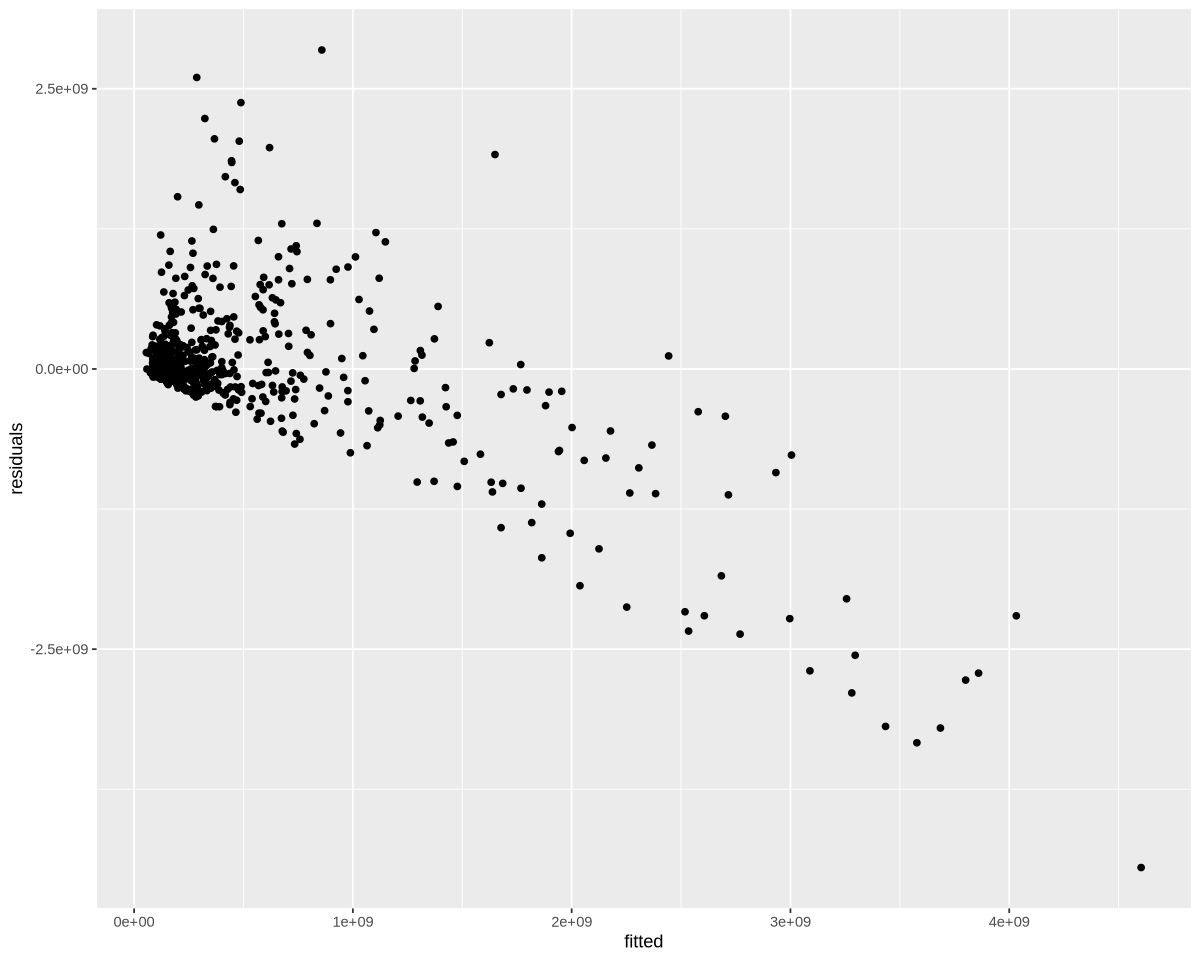

In [21]:
caption <- generate_figure_caption("Residuals vs. fitted Values for all artists")
cat(caption, "\n")
model_data_accuracy <- model_data %>% cbind('fitted' = predict(quasip_model, model_data, type = "response"))%>%
mutate(residuals = streams - fitted)

ggplot(model_data_accuracy, aes(y = residuals, x = fitted))+ geom_point()

The chart above shows that we systematically underpredict streams with our model. A potential reason for this is the fact that we grouped all artists with less than 5 songs under category "other". Since we don't calculate independent artist effects for them, these observations likely have large residuals. Below we look at the same plot but only for artists with over 5 songs on the dataset.

Figure 6 : Residuals vs. fitted Values for for artists with over 5 songs 


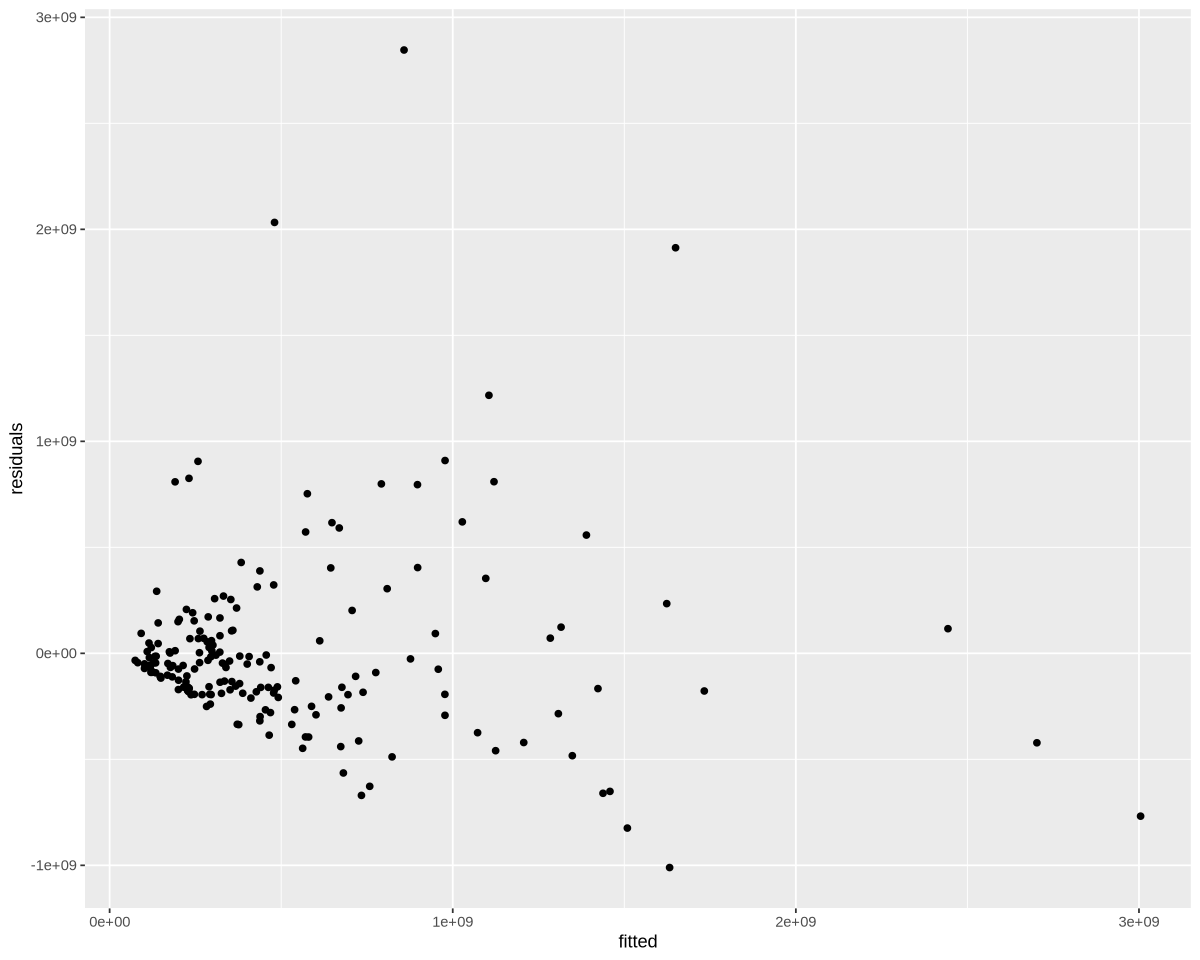

In [22]:
caption <- generate_figure_caption("Residuals vs. fitted Values for for artists with over 5 songs")
cat(caption, "\n")
selected_artists_accuracy <- model_data %>% 
filter(artist_name != "other")

selected_artists_accuracy <- selected_artists_accuracy %>% cbind('fitted' = predict(quasip_model, selected_artists_accuracy, type = "response"))%>%
mutate(residuals = streams - fitted)

ggplot(selected_artists_accuracy, aes(x= fitted, y = residuals))+ geom_point()

Naturally, the residuals are much better when we look only at *artists we have selected*. This is expected given the nature of the model (we optimize for minimal residuals) and the fact that we have specific dummies for the artists included in the plot above.

Now we turn to the $R^2$ to look at how well the model fits the data.

In [23]:
caption <- generate_table_caption("Comparison of R2 Between Full Dataset and Selected Artists")
cat(caption, "\n")
tibble('Full data' = rsq(model_data_accuracy, truth = streams, estimate = fitted)$.estimate,
'Only selected artists' = rsq(selected_artists_accuracy, truth = streams, estimate = fitted)$.estimate)

Table 7 : Comparison of R2 Between Full Dataset and Selected Artists 


Full data Only selected artists
1 0.1726709 0.5194438

Similarly, we see that the $R^2$ is much larger when we look only at the artists with specific dummies.

To check whether we were able to avoid multicollinearity, we calculate the VIF values of the variables in the context of our model. It does seem like we avoided multicollinearity since all VIF values are close to 1.

In [24]:
caption <- generate_table_caption("VIF values of variables of our model")
cat(caption, "\n")
vif(quasip_model)

Table 8 : VIF values of variables of our model 


GVIF     Df GVIF^(1/(2*Df))
artist_name      1.439430 15 1.012216       
bpm              1.159689  1 1.076889       
danceability     1.474322  1 1.214217       
valence          1.528021  1 1.236132       
energy           2.023822  1 1.422611       
acousticness     2.032568  1 1.425681       
instrumentalness 1.052169  1 1.025753       
liveness         1.041287  1 1.020435